### Load Octave-Python bridge

In [1]:
%load_ext oct2py.ipython
from oct2py import octave

### Install Octave packages

In [2]:
%%capture
%%octave
pkg load image
pkg load statistics
pkg load io

### Add CERR to Octave Path

In [3]:
%%octave
currDir = pwd();
CERR_path = '/cluster/home/iyera/CERR_Octave/CERR';
cd(CERR_path)
addToPath2(CERR_path)
cd(currDir)

### Pre-processing with CERR

In [4]:
%%capture
%%octave

function [scanOutC,maskOutC] = getPreprocData(configFile,planC)
  skipMaskExport = 0;
  scanNum = 1;
  optS = readDLConfigFile(configFile)
  [scanOutC, maskOutC] = extractAndPreprocessDataForDL(optS,...
    planC,skipMaskExport,scanNum);
  scanOutC = scanOutC{1}; 
  maskOutC = maskOutC{1};
end

In [134]:
%%capture
%%octave

scanC = cell(4,1);
maskC = cell(4,1);

# Eg.1 Crop to patient outline
sampleHNData = ['/cluster/home/iyera/CERR_Octave/CERR/Unit_Testing/',...
'data_for_cerr_tests/CERR_plans/head_neck_ex1_20may03_resamp.mat.bz2'];
configFile = '/cluster/home/iyera/jupyter_notebooks/sample_settings/sample_config1.json';

tmp = tempdir();
plan1C = loadPlanC(sampleHNData,tmp);
plan1C = updatePlanFields(plan1C);
[scanOutC,maskOutC] = getPreprocData(configFile,plan1C);
scanC{1} = scanOutC{1}{1};
maskC{1} = maskOutC{1}{1};

# Eg.2 Chaining cropping operations
sampleLungData = ['/cluster/home/iyera/CERR_Octave/CERR/Unit_Testing/',...
'data_for_cerr_tests/CERR_plans/lung_ex1_20may03.mat.bz2'];
configFile = '/cluster/home/iyera/jupyter_notebooks/sample_settings/sample_config2.json';
plan2C = loadPlanC(sampleLungData,tmp);
plan2C = updatePlanFields(plan2C);
[scanOutC,maskOutC] = getPreprocData(configFile,plan2C);
scanC{2} = scanOutC{1}{1};
maskC{2} = maskOutC{1}{1};

# Eg3. Transforming image orientation 
configFile = '/cluster/home/iyera/jupyter_notebooks/sample_settings/sample_config3.json';
[scanOutC,maskOutC] = getPreprocData(configFile,plan1C);
scanC{3} = scanOutC;
maskC{3} = maskOutC;

# Eg4. Chaining pre-processing operations
configFile = '/cluster/home/iyera/jupyter_notebooks/sample_settings/sample_config4.json';
[scanOutC,maskOutC] = getPreprocData(configFile,plan1C);
scanC{4} = scanOutC{1};
maskC{4} = maskOutC{1};

### Visualization

In [135]:
%octave_pull scanC maskC

In [58]:
import matplotlib.pyplot as plt
import numpy as np

cmaps = [plt.cm.Oranges,plt.cm.Oranges,plt.cm.Blues,plt.cm.Blues, \
             plt.cm.Purples,plt.cm.Greens]

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

def get_extent(img):
    img_size = np.shape(img)
    x = np.arange(0, img_size[0], dx)
    y = np.arange(0, img_size[1], dy)
    extent = np.min(x), np.max(x), np.min(y), np.max(y)


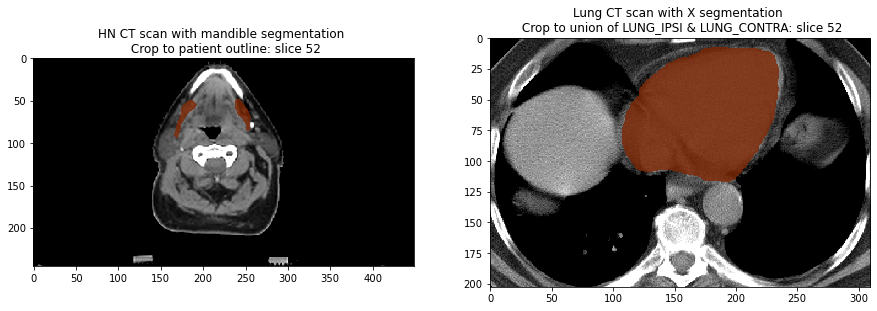

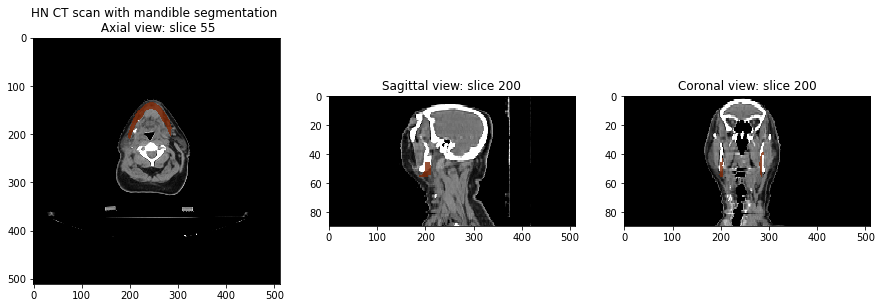

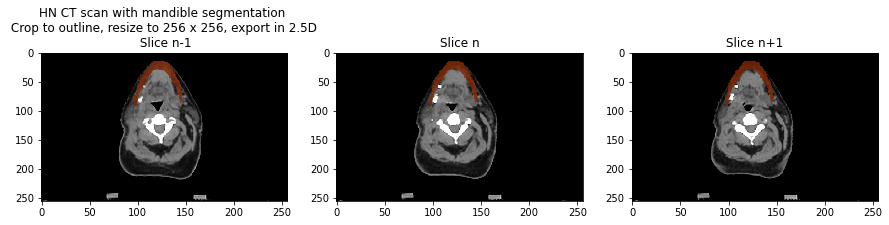

In [172]:
# Display processed data

def plotSelectedSlice(scanArray, maskArray, slice, title, ax, ar=1, addSlcFlag=1,):
    scanSize = np.shape(scanArray)

    window_center = 40
    window_width = 400
    extent = get_extent(scanArray)

    windowed_img = window_image(scanArray[:,:,slice],
                                window_center,window_width)
    ax.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
    interpolation='none', extent=extent)
    if addSlcFlag:
        title = title + ': slice ' + str(slice)
    ax.title.set_text(title)
    fontdict = {'fontsize' : 100}

    mask_cmap = cmaps[0]
    mask_cmap.set_under('k', alpha=0)
    im2 = ax.imshow(maskArray[:,:,slice-1], 
    cmap=mask_cmap, alpha=.8, extent=extent,
    clim=[0.5, 1],
    interpolation='none', ) 
    
    ax.set_aspect(ar)
    

#---- Display results of various preprocessing configurations ---

# Display results of config 1
scanArray = scanC[0][0]
maskArray = maskC[0][0]
slice = 52
plotTitle = 'HN CT scan with mandible segmentation \n Crop to patient outline'
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax1)       

# Display results of config 2
scanArray = scanC[1][0]
maskArray = maskC[1][0]
plotTitle = 'Lung CT scan with X segmentation \n Crop to union of LUNG_IPSI & LUNG_CONTRA'
plotSelectedSlice(scanArray, maskArray, slice, plotTitle,ax2)       

# Display results of config 3
scanViewC = scanC[2][0]   
maskViewC = maskC[2][0]  
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))

slice = 55
plotTitle = 'HN CT scan with mandible segmentation \n Axial view'
scanArray = scanViewC[0][0][0]
maskArray = maskViewC[0][0]
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax1)   
slice = 200
plotTitle = 'Sagittal view'
scanArray = scanViewC[1][0][0]
maskArray = maskViewC[1][0]
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax2, ar=3)  
plotTitle = 'Coronal view'
scanArray = scanViewC[2][0][0]
maskArray = maskViewC[2][0]
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax3, ar=3)       

#Display results of config4
scan25dC = scanC[3][0]
maskArray = maskC[3][0][0]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))
slice = 55

scanArray = scan25dC[0][0]
plotTitle = 'HN CT scan with mandible segmentation \n Crop to outline, resize to 256 x 256, export in 2.5D \n Slice ''n-1'''
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax1, ar=0.6, addSlcFlag=0)   

plotTitle = 'Slice ''n'''
scanArray = scan25dC[1][0]
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax2, ar=0.6, addSlcFlag=0)   

plotTitle = 'Slice ''n+1'''
scanArray = scanArray = scan25dC[2][0]
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax3, ar=0.6, addSlcFlag=0)   
